In [18]:
import io
from pathlib import Path
import pickle

import matplotlib.pyplot as plt

import torch

import numpy as np
from sklearn.mixture import GaussianMixture
%matplotlib inline

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

# run_id = 'SUB-849'
# run_id = 'SUB-1023'
run_id = 'SUB-1168'
path = Path('../data/models/checkpoints', run_id, 'embeddings.pkl')

# feature_bank, feature_labels, embedding, targets, label_names = pickle.load(open('embeds_379-cifar100.pkl', 'rb'))
# feature_bank, feature_labels, embedding, targets, label_names = pickle.load(open('embeds_379.pkl', 'rb'))
# feature_bank, feature_labels, embedding, targets, label_names = pickle.load(open('embeds_819.pkl', 'rb'))
# feature_bank, feature_labels, embedding, targets, label_names = pickle.load(open('embeds_820.pkl', 'rb'))
feature_bank, feature_labels, embedding, targets, label_names = CPU_Unpickler(open(path, 'rb')).load()

# pickle.dump((feature_bank, feature_labels, embedding, targets, self.dataset['train'].label_names), open('embeds_820.pkl' , 'wb'))

In [19]:
A = feature_bank.T
U, S, V = torch.pca_lowrank(A, q=20, center=True, niter=2)
# Train
X = U.cpu().numpy()
y = feature_labels.cpu().numpy()

print(torch.all(A==0))

# Val
E = ((embedding - A.mean(axis=0)) @ V @ torch.diag(1 / S)).cpu().numpy()
Ey = targets.cpu().numpy()

XE = np.concatenate((X, E))

tensor(False)


In [20]:
from sklearn.cluster import KMeans
from finch import FINCH
# c, num_clust, req_c = FINCH(A.cpu().numpy())
# print(c.shape, num_clust, req_c)
# A_kl = c.argmax(axis=1)
for n_c in [5]: #range(2,100):
    print(f"NC({n_c}")

    # km = KMeans(n_clusters=n_c)
    # A_kl = km.fit_predict(A.cpu().numpy())
    # A_kl = km.fit_predict(A.cpu().numpy())
    gm = GaussianMixture(n_components=n_c).fit(X)
    A_kl = gm.predict(X)

    # Assuming A_kl contains the cluster labels
    unique_labels, counts = np.unique(A_kl, return_counts=True)

    # Print the number of samples per cluster
    for label, count in zip(unique_labels, counts):
        print(f"Cluster {label}: {count} samples")

    import numpy as np

    # Create the contingency table
    contingency_table = np.zeros((len(np.unique(y)), len(np.unique(A_kl))))
    for true_label, cluster_label in zip(y, A_kl):
        contingency_table[true_label, cluster_label] += 1

    # Compute the probabilities
    probabilities = np.zeros(len(np.unique(y)))
    for i, row in enumerate(contingency_table):
        max_count = np.max(row)
        total_count = np.sum(row)
        probabilities[i] = max_count / total_count

    # # Print the probabilities
    # for i, prob in enumerate(probabilities):
    #     print(f"Probability for true label {i}: {prob:.2f}")

    print(f"Mean: {np.mean(probabilities)}")

    from sklearn.metrics import adjusted_mutual_info_score

    # gm = GaussianMixture(n_components=100).fit(X)
    # A_kl = gm.predict(X)
    print(A_kl.shape, y.shape)
    ad = adjusted_mutual_info_score(A_kl, y)
    print(f"ADJ={ad}")

NC(5
Cluster 0: 24465 samples
Cluster 1: 20804 samples
Cluster 2: 39001 samples
Cluster 3: 30600 samples
Cluster 4: 23124 samples
Mean: 0.6935136543583595
(137994,) (137994,)
ADJ=0.19852798925360468


In [21]:
torch.save(A_kl, 'output_clusters.pt')
torch.save(gm, 'output_gm.pt')
torch.save(((A, U, S, V, E)), 'output_pca.pt')

In [22]:
import time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
t0 = time.time()
XE_reduced = tsne.fit_transform(XE)
t1 = time.time()

X_reduced = XE_reduced[:len(X)]
E_reduced = XE_reduced[len(X):]

t1 - t0

/home/ook/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ook/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


1716.0031821727753

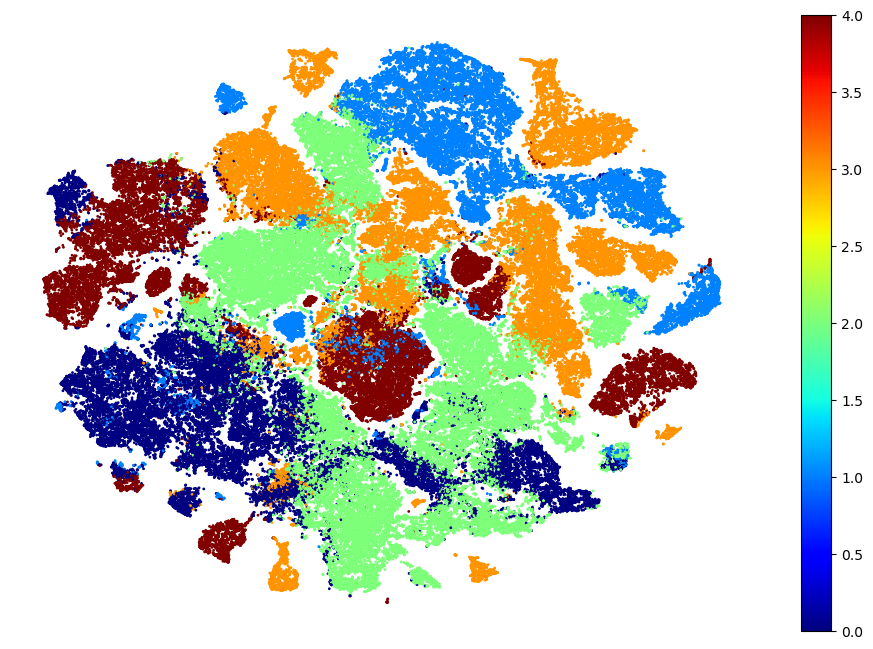

In [23]:
plt.figure(figsize=(12, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=A_kl, cmap='jet', marker='o', s=1.0)
plt.colorbar()
plt.axis('off')
plt.show()

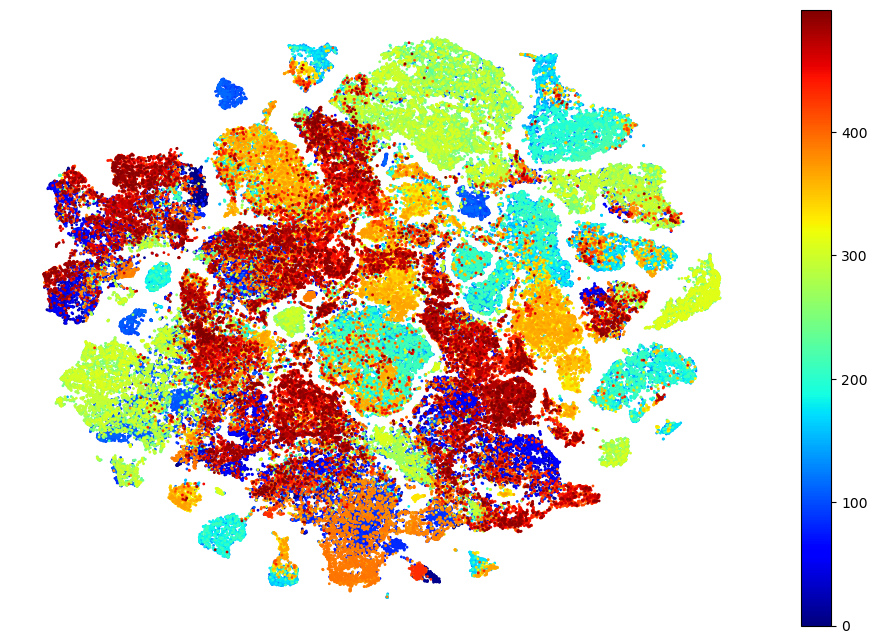

In [24]:
plt.figure(figsize=(12, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='jet', marker='o', s=1.0)
plt.colorbar()
plt.axis('off')
plt.show()